# QPE おもちゃ


In [1]:
import numpy as o_np #pennylaneのnumpyと被らないように
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
import pennylane as qml 
from pennylane import numpy as np
import openfermion as of
from pennylane.templates import QuantumPhaseEstimation

0.5000000005803411


/Users/sym4p/my_python3_env_forQC/lib/python3.13/site-packages/pennylane/ops/op_math/controlled_ops.py:163: UserWarning: base operator already has wires; values specified through wires kwarg will be ignored.
  warnings.warn(


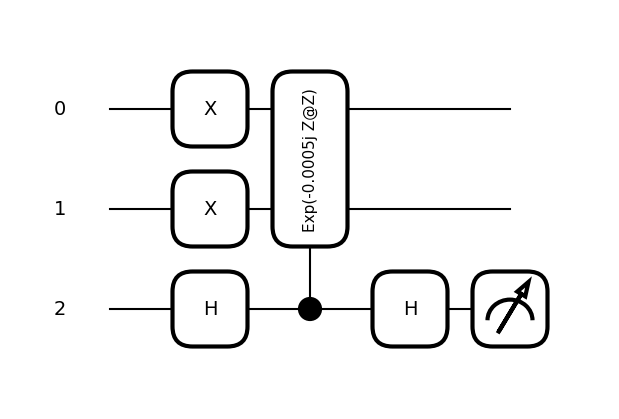

In [ ]:
# まずHadamard test

Norb = 2
n_ancilla = 1

dev = qml.device("default.qubit", wires=n_ancilla+Norb)

@qml.qnode(dev)
def circuit(method, time_step, trotter_step):
    estimation_wires = list(range(Norb, Norb+n_ancilla))

    # State preparation
    if method == 0:
        qml.PauliX(0)
        qml.PauliX(1)
    elif method == 1:
        qml.Hadamard(0)
        qml.Hadamard(1)
    elif method == 2:
        qml.Ry(o_np.pi/3)

    # Time Evolution

    # op1 = qml.Identity(0) - qml.PauliZ(0) 
    # op2 = qml.Identity(1) - qml.PauliZ(1)
    # op = op1 @ op2
    # coeff = 0.25
    # U = qml.exp(op, coeff= 1.j * coeff*time_step, num_steps=trotter_step)

    op1 = qml.PauliZ(0) 
    op2 = qml.PauliZ(1)
    op = op1 @ op2
    coeff =  0.5
    U = qml.exp(op, coeff= 1.j * coeff*time_step, num_steps=trotter_step)


    # Hadamard test
    qml.Hadamard(wires=estimation_wires)
    qml.ControlledQubitUnitary(U, control_wires=estimation_wires, wires=range(0, Norb))
    qml.Hadamard(wires=estimation_wires)
    return qml.expval(qml.PauliZ(estimation_wires))

method = 0
trotter_step = 100
time_step = 1.e-3

fig, ax  = qml.draw_mpl(circuit, show_all_wires=True)(method, time_step, trotter_step)
res = circuit(method, time_step, trotter_step)

lambda_t = np.arccos(res.item())
lambda_ = lambda_t / time_step
print(lambda_)

同じ系をQPEで計算

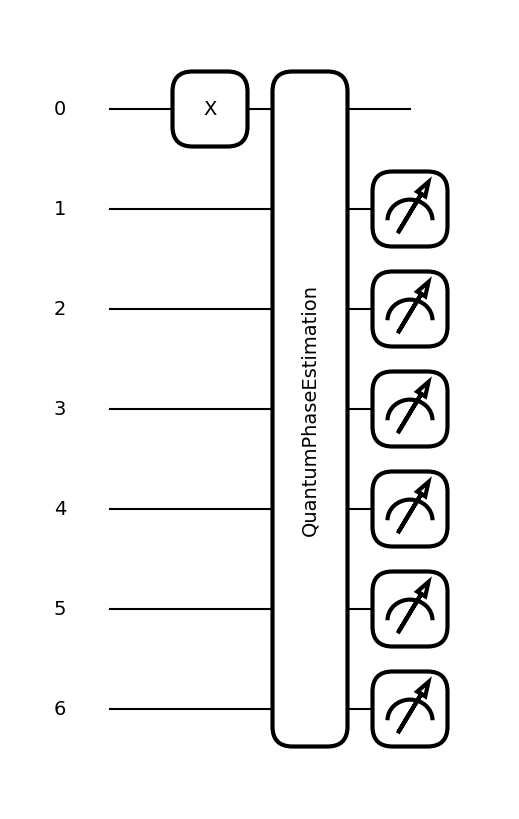

In [71]:
Norb = 1
n_ancilla = 6

dev = qml.device("default.qubit", wires=n_ancilla+Norb)

@qml.qnode(dev)
def circuit(method, time_step, trotter_step):
    estimation_wires = list(range(Norb, Norb+n_ancilla))

    # State preparation
    if method == 0:
        qml.PauliX(wires=[0])
    elif method == 1:
        qml.Hadamard([0])
    elif method == 2:
        qml.RY(np.pi/3, wires=[0])

    # Time Evolution
    op = 1 - qml.PauliZ(wires=0)
    U = qml.exp(op, coeff= 1.j * time_step, num_steps=trotter_step)
    # print("U ", U)

    # for q in estimation_wires:
    #     qml.Hadamard(q)
    # qml.ControlledSequence(op, control=estimation_wires)
    # qml.adjoint(qml.QFT)(wires=estimation_wires)

    QuantumPhaseEstimation(
        U,
        estimation_wires=estimation_wires,
    )
    return qml.probs(estimation_wires)

method = 0
trotter_step = 1
time_step = 3.e-2

fig, ax  = qml.draw_mpl(circuit, show_all_wires=True)(method, time_step, trotter_step)
res = circuit(method, time_step, trotter_step)

In [72]:
def float_from_binary(binary):
    return sum([int(x) * 2**(-i-1) for i, x in enumerate(binary[2:])])
#print("0.0011 => ", float_from_binary("0.0011"))

ancilla_wires = list(range(Norb, Norb+n_ancilla))
bit_strings = [f"0.{x:0{len(ancilla_wires)}b}" for x in range(len(res))]

idxs = o_np.argsort(res)
for i in range(5):
      idx = idxs[-i-1]
      val = float_from_binary(bit_strings[idx])
      bit_str = bit_strings[idx]
      val2pi = val * 2 * np.pi / time_step
      print(f"{i}th most freq", bit_str, "prob.", res[idx], "value", val/time_step, "*2pi", val2pi)


0th most freq 0.000001 prob. 0.5917359706661997 value 0.5208333333333334 *2pi 3.272492347489368
1th most freq 0.000000 prob. 0.2395829383646416 value 0.0 *2pi 0.0
2th most freq 0.000010 prob. 0.04645085133904782 value 1.0416666666666667 *2pi 6.544984694978736
3th most freq 0.111111 prob. 0.034534990107576685 value 32.8125 *2pi 206.1670178918302
4th most freq 0.000011 prob. 0.015748668678969176 value 1.5625 *2pi 9.817477042468104


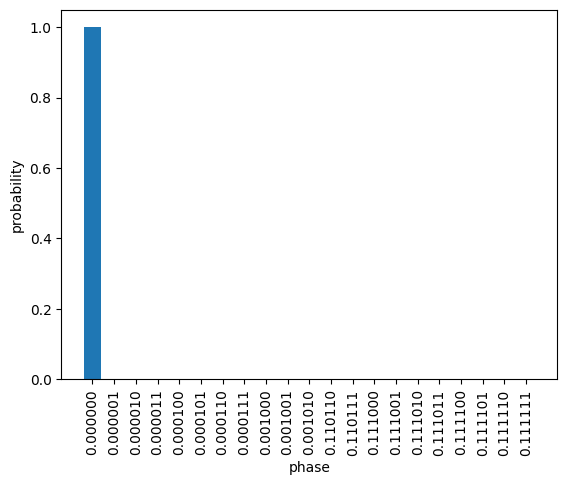

In [51]:
idxs = [ i for i, x in enumerate(res) if x > 1.e-6]
x = [tmp for i, tmp in enumerate(bit_strings) if i in idxs]
y = [tmp for i, tmp in enumerate(res) if i in idxs]
fig = plt.figure()
plt.bar(x,y)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.show()

In [113]:
phase = 4

n_estimation_wires = 10
time_step = 1.e-2
target_wires = [0]
estimation_wires = range(1, n_estimation_wires + 1)

unitary = qml.RX(phase, wires=0).matrix() #* time_step

dev = qml.device("default.qubit", wires=n_estimation_wires + 1)

@qml.qnode(dev)
def circ():
    # Start in the |+> eigenstate of the unitary
    qml.Hadamard(wires=target_wires)

    QuantumPhaseEstimation(
        unitary,
        target_wires=target_wires,
        estimation_wires=estimation_wires,
    )

    return qml.probs(estimation_wires)

res = circ()
print(res)
phase_estimated = np.argmax(res) / 2 ** n_estimation_wires
print("Estimated phase:", phase_estimated, "idx", np.argmax(res), "bit", bin(np.argmax(res)))
# Need to rescale phase due to convention of RX gate
phase_estimated = 4 * np.pi * (1 - phase_estimated)
print("Estimated phase:", phase_estimated)


[3.38503555e-08 3.37177008e-08 3.35864554e-08 ... 3.42569378e-08
 3.41199575e-08 3.39844356e-08]
Estimated phase: 0.681640625 idx 698 bit 0b1010111010
Estimated phase: 4.000621894805752
